In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 
from numpy.fft import fftshift
from tqdm import tqdm

import lensit as li
from lensit.clusterlens import lensingmap, profile 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat
from plancklens.wigners import wigners
from plancklens import n0s, nhl
from plancklens.n1 import n1

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline

mpi.py: Plancklens.mpi disabled as per environ variable 



In [2]:
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname('/Users/sayan/CMB_WORK/CAMB-1.1.3/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [64]:
# We define here the parameters for the profile of the cluster
M200, z = 4 * 1e14, 0.7
profname = 'nfw'
key = "cluster" # "lss"/"cluster"/"lss_plus_cluster"
profparams={'M200c':M200, 'z':z}
hprofile = profile.profile(results, profname)
xmax = 3*hprofile.get_concentration(M200, z)
# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(npix*lpix_amin, npix*lpix_amin))

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 6002 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 5000
ellmindat = 100

# Number of simulated maps 
nsims = 1000

# Set CMB experiment for noise level and beam
cmb_exp='S4_no_noise'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile,  profname, key, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
libdir = op.join(libdir,"trunc")
print(libdir)

The size of the data patch is 307.2 X 307.2 arcmin central box
/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc


In [8]:
lmax = ellmaxsky
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_gradient_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_gradlen_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[4], 'pp':cpp_fid}


In [65]:
np.random.seed(seed=20)
clustermaps = lensingmap.cluster_maps(libdir, key, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, ellmin_data=ellmindat, cmb_exp=cmb_exp)

/Users/sayan/Project_Geneva/modules/LensIt/lensit/ffs_covs/ell_mat.py:49: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/ellmats/ellmat_npix1024_lpix_0.3amin/ellmat_hash.pk'>
  hash_check(pk.load(open(fn_hash, 'rb')), self.hash_dict())
/Users/sayan/Project_Geneva/modules/LensIt/lensit/sims/sims_generic.py:93: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/len_alms/skypha/ffs_pha_0000/sim_hash.pk'>
  pk.dump(self.hashdict(), open(fn, 'wb'), protocol=2)
/Users/sayan/Project_Geneva/modules/LensIt/lensit/sims/sims_generic.py:96: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_clus

 [00:00:29] Generating CMB phases ---------> 99%


/Users/sayan/Project_Geneva/modules/LensIt/lensit/sims/ffs_cmbs.py:122: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/len_alms/sim_hash.pk'>
  pk.dump(self.hashdict(), open(fn_hash, 'wb'), protocol=2)
/Users/sayan/Project_Geneva/modules/LensIt/lensit/sims/ffs_cmbs.py:124: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/len_alms/sim_hash.pk'>
  sims_generic.hash_check(self.hashdict(), pk.load(open(fn_hash, 'rb')))
/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:321: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 

 [00:01:59] Generating Noise phases ---------> 99%


/Users/sayan/Project_Geneva/modules/LensIt/lensit/sims/ffs_maps.py:210: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/lmaxdat5000/maps/sim_hash.pk'>
  pk.dump(self.hashdict(), open(fn_hash, 'wb'), protocol=2)
/Users/sayan/Project_Geneva/modules/LensIt/lensit/sims/ffs_maps.py:212: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/lmaxdat5000/maps/sim_hash.pk'>
  hash_check(self.hashdict(), pk.load(open(fn_hash, 'rb')))


In [6]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1.) ** 2 * 0.25 

def p_to_k(ls):
    return ls * (ls+1.) * 0.5

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

def k_to_p(ls):
    return cli(p_to_k(ls))

def th_amin_to_el(th_amin):
    th_rd = (th_amin/60)*(np.pi/180)
    return np.pi/th_rd

In [66]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)

cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls
# cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
# lib_alm = ell_mat.ffs_alm_pyFFTW(get_ellmat(LD_res, HD_res=HD_res),
                    # filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax), num_threads=pyFFTWthreads)
# lib_skyalm = ell_mat.ffs_alm_pyFFTW(clustermaps.ellmat,
                    # filt_func=lambda ell: (ell <= ellmax_sky), num_threads=clustermaps.num_threads)

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm

typ = 'T'

lib_dir = op.join(clustermaps.dat_libdir, typ)
# isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, cls_len, cl_transf, cls_noise, lib_skyalm=lib_skyalm)
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, cls_unl_fid, cls_unl_fid, cl_transf, cls_noise, lib_skyalm=lib_skyalm)

/Users/sayan/Project_Geneva/modules/LensIt/lensit/ffs_covs/ffs_cov.py:88: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/lmaxdat5000/T/cov_hash.pk'>
  pk.dump(self.hashdict(), open(fn, 'wb'), protocol=2)
/Users/sayan/Project_Geneva/modules/LensIt/lensit/ffs_covs/ffs_cov.py:90: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/lmaxdat5000/T/cov_hash.pk'>
  hash_check(pk.load(open(fn, 'rb')), self.hashdict())


In [67]:
H0len =  isocov.get_response(typ, lib_skyalm, use_cls_len=True)[0]
#H0len = phi_var_3
def get_starting_point(idx, typ, clustermaps, keyword=None): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 

    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
 
    lib_qlm = lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    ellmax_sky = lib_skyalm.ellmax
    ell = np.arange(ellmax_sky+1)

    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap(idx))]) 
    elif typ =='TQU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in np.array([clustermaps.maps_lib.get_sim_tmap(idx), clustermaps.maps_lib.get_sim_qumap(idx)[0], clustermaps.maps_lib.get_sim_qumap(idx)[1]])]) 
   
    use_cls_len = True
 
    plm1 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len)[0]
    plm_c1 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len, ellmax_gradleg=2000)[0]
    # Normalization and Wiener-filtering:
    plmqe1  = lib_qlm.almxfl(plm1, cli(H0len), inplace=False)

    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.

    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap_unl(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap_unl(idx))]) 
    elif typ =='TQU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in np.array([clustermaps.maps_lib.get_sim_tmap_unl(idx), clustermaps.maps_lib.get_sim_qumap_unl(idx)[0], clustermaps.maps_lib.get_sim_qumap_unl(idx)[1]])]) 


    plm2 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len)[0]
    
    # Normalization and Wiener-filtering:
    plmqe2  = lib_qlm.almxfl(plm2, cli(H0len), inplace=False)
    
    plm_c2 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len, ellmax_gradleg=2000)[0]

    return  plm1 , plm2, plm_c1, plm_c2


idx = 0
plm1 , plm2, plm_c1, plm_c2  = get_starting_point(idx, typ, clustermaps)

  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   inverse len Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fyy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxy , part 2  curvpOlm 
 I will be using data from ell=140 to ell=5000 only
 The sky band-limit is ell=6002
Building nufft fwd plan
     _get_pmati:: cached /Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_no_noise/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1000_sims/trunc/lmaxdat5000/T/T_Pmatinv_len_00.npy
     [00:00:00]  (total 

In [68]:
nmaps = 1000
plms1 = [None]*nmaps
plms2 = [None]*nmaps
plms = [None]*nmaps
plms_c1 = [None]*nmaps
plms_c2 = [None]*nmaps
plmsc = [None]*nmaps

if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plms1[idx], plms2[idx], plms_c1[idx], plms_c2[idx] = get_starting_point(idx, typ, clustermaps)
        plms[idx] = plms1[idx] - plms2[idx]
        plmsc[idx] = plms_c1[idx] - plms_c2[idx]

0
 I will be using data from ell=140 to ell=5000 only
 The sky band-limit is ell=6002
Building nufft fwd plan
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=140 to ell=50

In [70]:
#H0len_1 = np.loadtxt("./emp_response/H0len_wc_lmax4k_out6k.txt")
H0len_2 = np.loadtxt("./emp_response/H0len_gad_cut_lmax5k_out6k_wo_noise.txt")


In [69]:
ell, = np.where(isocov.lib_skyalm.get_Nell()[:ellmaxsky+1])
el = ell[1:]

In [82]:
el[el<1500].shape

(162,)

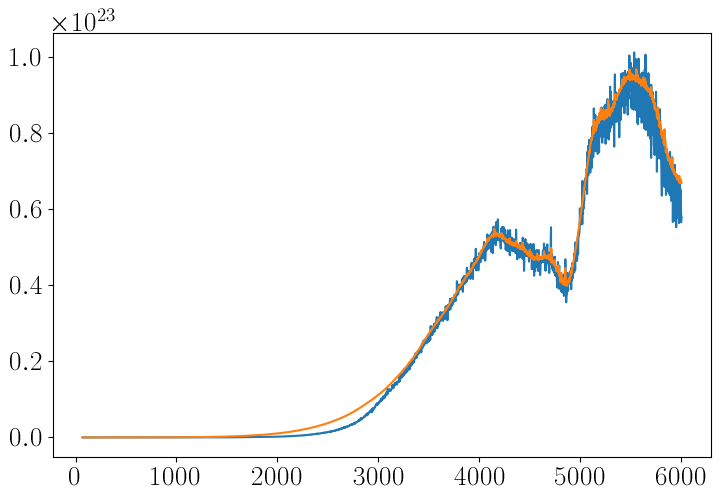

In [71]:
plt.plot(el, H0len_2[el])
plt.plot(el, H0len[el])


In [77]:
ell = np.arange(ellmax_sky+1)
plm_mean_1 = np.mean(plms, axis=0)
plm_mean_2 = np.mean(plmsc, axis=0)
kappa_l_mean_1 = lib_skyalm.bin_realpart_inell(plm_mean_1)*p_to_k(ell)*cli(H0len)
kappa_l_mean_2 = lib_skyalm.bin_realpart_inell(plm_mean_2)*p_to_k(ell)*cli(H0len_2)

In [16]:
ell = np.arange(ellmax_sky+1)

lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)
kappa_map = clustermaps.len_cmbs.kappa_map
from scipy.interpolate import UnivariateSpline
kappa_ell_bin = lib_skyalm.bin_realpart_inell(lib_skyalm.map2alm(kappa_map))[ell]
kappa_ell_lensit = UnivariateSpline(ell, kappa_ell_bin, s=0)
kappa_l = kappa_ell_lensit(ell)

In [17]:
ft_anal = hprofile.analitic_kappa_ft(M200, z, xmax, ell)

/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:191: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:192: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * xmax) / (x * (1. + xmax))


In [61]:
ell, = np.where(isocov.lib_skyalm.get_Nell()[:6002+1])
el = ell[1:]

In [24]:
kappa_l_mean = np.loadtxt("./clusterfiles/lmax5k_out6k_M4/kappa_l_MAP_lss_nit20.dat")

In [53]:
kappa_l_mean_old = np.loadtxt("/Users/sayan/Project_Geneva/cluster_lensing_files-main/Final_notebooks/CSTMF/June23/cluster_runs/files_max5k_out6k/kappa_l_MAP_lss.dat")

In [63]:
np.savetxt("./clusterfiles/lmax5k_out6k_M4/kappa_l_QE.dat", np.array([kappa_l_mean_1, kappa_l_mean_2, ft_anal]))

<>:9: DeprecationWarning: invalid escape sequence \e
<>:10: DeprecationWarning: invalid escape sequence \k
<>:9: DeprecationWarning: invalid escape sequence \e
<>:10: DeprecationWarning: invalid escape sequence \k
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_76479/4154870161.py:9: DeprecationWarning: invalid escape sequence \e
  plt.xlabel("$\ell$")
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_76479/4154870161.py:10: DeprecationWarning: invalid escape sequence \k
  plt.ylabel("$\kappa_\ell$")


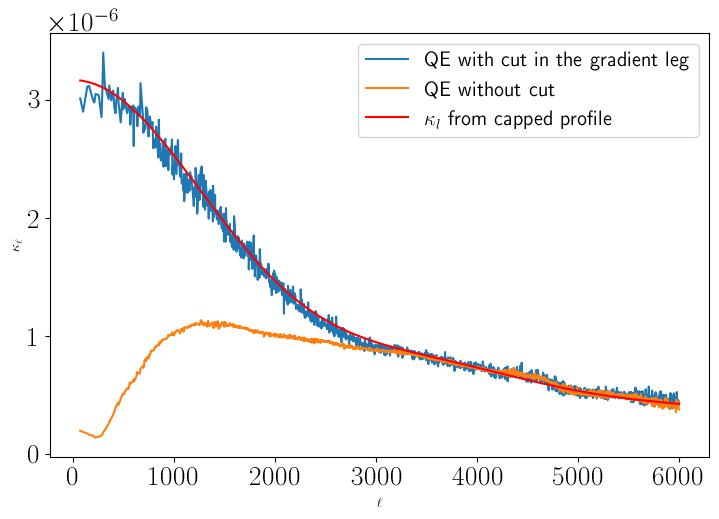

In [78]:

plt.plot(el, kappa_l_mean_2[el], label="QE with cut in the gradient leg")
plt.plot(el, kappa_l_mean_1[el], label="QE without cut")
#plt.plot(el, kappa_l_mean[el], label="MAP lmax_out=6k")
#plt.plot(el, kappa_l_mean_old[el], label="MAP lmax_out=5k")
plt.plot(el, kappa_l[el], c="r", label=r'$\kappa_l$ from capped profile')
#plt.plot(el, ft_anal[el]/(lbox_rad), c="k", label=r'$\kappa_l^{analytical}$')

#plt.semilogy()
plt.xlabel("$\ell$")
plt.ylabel("$\kappa_\ell$")
plt.legend()
#plt.savefig("../plots/kappa_l.pdf")

In [26]:
from scipy.special import jv
def kappa_th_bessel(theta_amin, kappa_l, elmax):
    el_r, = np.where(lib_skyalm.get_Nell()[:elmax+1])
    el_range = el_r[1:]
    theta_rad = theta_amin * np.pi / 60 / 180
    kappa_el = kappa_l[el_range]
    bessel = jv(1, el_range*theta_rad)
    integrand = el_range*kappa_el*bessel
    kappa_el1 = np.trapz(integrand, el_range)/ 2 / np.pi 
    return kappa_el1

from scipy.special import jv
def kappa_th_bessel_1(theta_amin, kappa_l, elmax):
    el_r, = np.where(lib_skyalm.get_Nell()[:elmax+1])
    el_range = el_r[1:]
    theta_rad = theta_amin * np.pi / 60 / 180
    kappa_el = kappa_l[el_range]
    bessel = jv(0, el_range*theta_rad)
    integrand = el_range*kappa_el*bessel
    kappa_el1 = np.trapz(integrand, el_range)/ 2 / np.pi 
    return kappa_el1

In [27]:
# function to go from kappa_l to alpha_l
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1.) ** 2 * 0.25 

def p_to_k(ls):
    return ls * (ls+1.) * 0.5

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

def k_to_p(ls):
    return cli(p_to_k(ls))

def th_amin_to_el(th_amin):
    th_rd = (th_amin/60)*(np.pi/180)
    return np.pi/th_rd

def alpha_to_k(ls):
    return ls * 0.5

def k_to_alpha(ls):
    return cli(alpha_to_k(ls))

In [34]:
theta = np.linspace(0.0, 100, 1000)

In [28]:
ell = np.arange(ellmaxsky+1)
#alpha_l = kappa_l/(ell_r) * 2
alpha_l_anal = ft_anal*k_to_alpha(ell)

In [34]:
lmax_int = 5000
theta = np.linspace(0.0, 100, 1000)
kappa_thet_bessel = np.zeros((len(theta)))
kappa_thet_bessel_lss = np.zeros((len(theta)))
kappa_thet_bessel_uc = np.zeros((len(theta)))
kappa_thet_bessel_c = np.zeros((len(theta)))
kappa_thet_bessel_ = np.zeros((len(theta)))
kappa_thet_bessel_wc = np.zeros((len(theta)))
for th in tqdm(range(len(theta))):
    kappa_thet_bessel[th] = kappa_th_bessel(theta[th], kappa_l*k_to_alpha(ell), elmax=lmax_int)
    kappa_thet_bessel_uc[th] = kappa_th_bessel(theta[th], ft_anal*k_to_alpha(ell), elmax=lmax_int)

    kappa_thet_bessel_[th] = kappa_th_bessel(theta[th], kappa_l_mean[ell]*k_to_alpha(ell), elmax=lmax_int)
    #kappa_thet_bessel_lss[th] = kappa_th_bessel(theta[th], kappa_l_mean_lss[ell]*k_to_alpha(ell), elmax=lmax_int)
    kappa_thet_bessel_c[th] = kappa_th_bessel(theta[th], kappa_l_mean_2[ell]*k_to_alpha(ell), elmax=lmax_int)
    kappa_thet_bessel_wc[th] = kappa_th_bessel(theta[th], kappa_l_mean_1[ell]*k_to_alpha(ell), elmax=lmax_int)

100%|██████████| 1000/1000 [00:13<00:00, 75.23it/s]


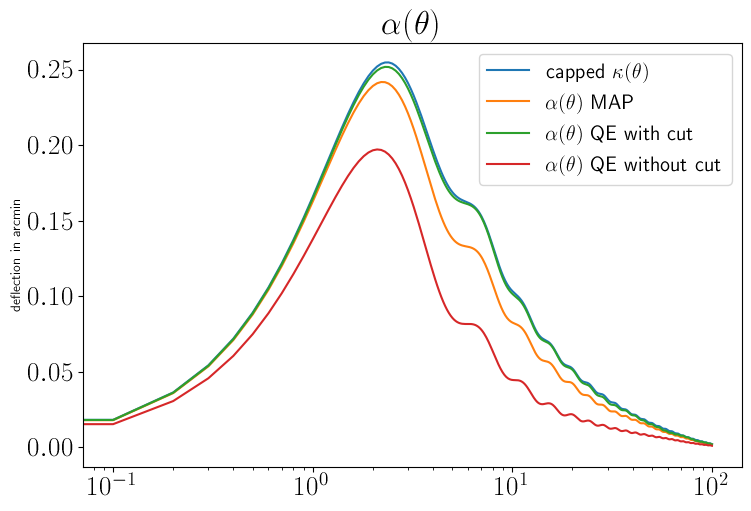

In [37]:
plt.plot(theta, kappa_thet_bessel*lbox_rad* 60 *180 / np.pi, label=r" capped $\kappa(\theta)$")
#plt.plot(theta, kappa_thet_bessel_uc * 60 *180 / np.pi , label=r" $\alpha(\theta)$ lmax=200k")
#plt.plot(theta, kappa_thet_bessel_uc * 60 *180 / np.pi , label=r" $\alpha(\theta)$ analytical")
plt.plot(theta, kappa_thet_bessel_ * lbox_rad* 60 *180 / np.pi , label=r" $\alpha(\theta)$ MAP")
#plt.plot(theta, kappa_thet_bessel_lss * lbox_rad* 60 *180 / np.pi , label=r" $\alpha(\theta)$ MAP-LSS")
plt.plot(theta, kappa_thet_bessel_c * lbox_rad * 60 *180 / np.pi , label=r" $\alpha(\theta)$ QE with cut")
plt.plot(theta, kappa_thet_bessel_wc * lbox_rad * 60 *180 / np.pi , label=r" $\alpha(\theta)$ QE without cut")
# Add a horizontal line at zero
#plt.axhline(y=0, c="r")
plt.semilogx()
plt.ylabel("deflection in arcmin")
plt.title(r"$\alpha(\theta)$")
plt.legend()

In [40]:
lmax_int = 5001
theta = np.linspace(0.0, 10, 1000)
kappa_thet_bessel = np.zeros((len(theta)))
kappa_thet_bessel_uc = np.zeros((len(theta)))
kappa_thet_bessel_c = np.zeros((len(theta)))
kappa_thet_bessel_ = np.zeros((len(theta)))
kappa_thet_bessel_wc = np.zeros((len(theta)))
for th in tqdm(range(len(theta))):
    kappa_thet_bessel[th] = kappa_th_bessel_1(theta[th], kappa_l, elmax=lmax_int)
    kappa_thet_bessel_uc[th] = kappa_th_bessel_1(theta[th], ft_anal, elmax=lmax_int)
    #kappa_thet_bessel_lss[th] = kappa_th_bessel_1(theta[th], kappa_l_mean_lss[ell], elmax=lmax_int)
    kappa_thet_bessel_[th] = kappa_th_bessel_1(theta[th], kappa_l_mean[ell], elmax=lmax_int)
    kappa_thet_bessel_c[th] = kappa_th_bessel_1(theta[th], kappa_l_mean_2[ell], elmax=lmax_int)
    kappa_thet_bessel_wc[th] = kappa_th_bessel_1(theta[th], kappa_l_mean_1[ell], elmax=lmax_int)

100%|██████████| 1000/1000 [00:11<00:00, 85.80it/s]


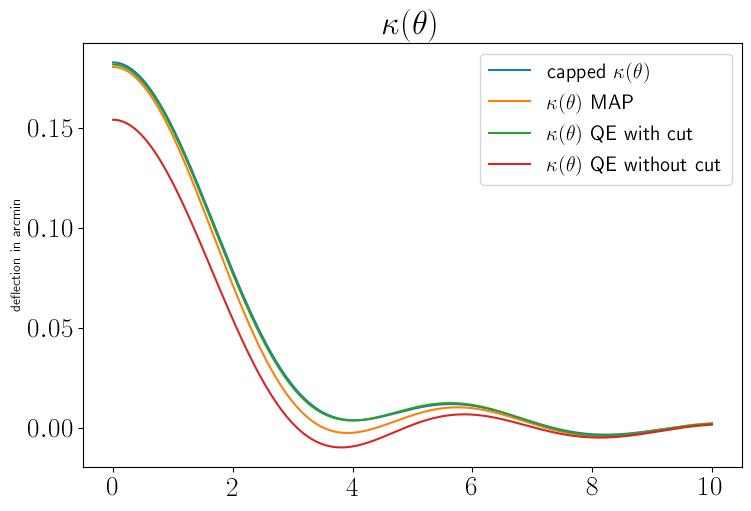

In [42]:
plt.plot(theta, kappa_thet_bessel*lbox_rad, label=r" capped $\kappa(\theta)$")
#plt.plot(theta, kappa_thet_bessel_uc  , label=r" $\kappa(\theta)$ lmax=200k")
#plt.plot(theta, kappa_thet_bessel_uc  , label=r" $\kappa(\theta)$ analytical")
#plt.plot(theta, kappa_thet_bessel_lss * lbox_rad , label=r" $\kappa(\theta)$ MAP-Lss")
plt.plot(theta, kappa_thet_bessel_ * lbox_rad , label=r" $\kappa(\theta)$ MAP")
plt.plot(theta, kappa_thet_bessel_c * lbox_rad  , label=r" $\kappa(\theta)$ QE with cut")
plt.plot(theta, kappa_thet_bessel_wc * lbox_rad  , label=r" $\kappa(\theta)$ QE without cut")
# Add a horizontal line at zero
#plt.axhline(y=0, c="r")
#plt.semilogx()
plt.ylabel("deflection in arcmin")
plt.title(r"$\kappa(\theta)$")
plt.legend()